**Modélisation de l'émission de CO2 des bâtiments non-résidentiels dans la ville de Seattle.**

# Dataframe import

**Modélisation de la consommation des bâtiments non-résidentiels dans la ville de Seattle.**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Modélisation de la consommation des bâtiments non-résidentiels dans la ville de Seattle.**

In [ ]:
path ='/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 4/Content/df_feat.csv'
df_bis_std_enc=pd.read_csv(path,sep=',').drop(['Unnamed: 0'], axis=1)

# Feature selection

**Modélisation de la consommation des bâtiments non-résidentiels dans la ville de Seattle.**

In [ ]:
UseType_GFA=['Office',
            'Other',
            'Public_services',
            'Restaurant_hotel_health',
            'Storage',
            'Store']

Neighborhood=['Neighborhood_CENTRAL',
            'Neighborhood_DOWNTOWN',
            'Neighborhood_GREATER DUWAMISH',
            'Neighborhood_NORTH',
            'Neighborhood_SOUTH',
            'Neighborhood_WEST']

Council=['CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']

Coordinat=['Latitude',
          'Longitude']

Ratio_energy=['RatioElectricityUse',
            'RatioSteamUse',
            'RationNaturalGazUse']

Property_caract=['PropertyGFABuilding(s)',
                'BuildingAge',
                'NumberofBuildings',
                'NumberofFloors']

Target_1=['SiteEnergyUseWN(kBtu)']
Target_2=['TotalGHGEmissions']

**Modélisation de la consommation des bâtiments non-résidentiels dans la ville de Seattle.**

In [ ]:
# Features and Targets listes
Features = UseType_GFA + Neighborhood + Council + Coordinat + Ratio_energy + Property_caract
Targets = Target_2

In [ ]:
# copy in a new dataframe
df_feat = df_bis_std_enc[Features + Targets].copy()

In [ ]:
df_feat.shape

(1470, 29)

In [ ]:
df_bis_std_enc[Target_1+Target_2].corr()

,SiteEnergyUseWN(kBtu),TotalGHGEmissions
SiteEnergyUseWN(kBtu),1.000000,0.884739
TotalGHGEmissions,0.884739,1.000000


# First modelisation

Dans cette partie nous allons dans un premier temps tester l'impact de plusieurs types de normalisation de nos variables sur des modèles linéaires simples afin d'établir une première base de l'état d'entrée optimal pour le modèle final.

Dans un second temps nous sélectionnerons un estimateur plus performant sur la base de la première base obtenu.

Enfin nous testerons de nouveau plusieurs configuration d'entrées avec l'estimateur retenons avant d'optiminer ses hyperparamètres pour optenir les meileurs prédictions que possible.

In [ ]:
X = df_feat[Features]
y = df_feat[Targets]

import des modules nécessaires à lentrainement et validation de modèles, ainsin que des premier estimateurs linéaires à tester.

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=100, stratify=pd.qcut(np.array(y).reshape(1,-1)[0], 10))

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

La fonction ci-dessous nous permettra de compiler des résultats de gridsearchCV sur plusieurs estimeteurs ce qui nous aidera pour les comparer.

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV


def Model_Trainer(param_grid, estimators):

  skf = KFold(n_splits=5, shuffle=True, random_state=42)

  result = []
  esti_name = []

  for esti in estimators:
    gridsearch = GridSearchCV(
        esti, param_grid,
        scoring=['neg_root_mean_squared_error','r2'],
        cv=skf.split(X_train,y_train), refit='r2', verbose=0)

    gridsearch.fit(X_train, y_train)

    result.append([gridsearch.best_params_, gridsearch.best_score_])
    esti_name.append(str(esti))

  tab_result = pd.DataFrame(result, columns = ['best_params_', 'best_score_'], index = esti_name)

  return(tab_result)

## Feature setting

In [ ]:
from sklearn.compose import ColumnTransformer
from scipy.stats import yeojohnson
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
X.shape

(1470, 28)

## Model setting

#### Feature engineering

Fonctions permettant de faire de la validation croisée sur plusieurs configuration de nos variables d'entrées :

In [ ]:
# fonction qui transforme en std, minmax ou yeo sur colonnes souhaitées
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from scipy.stats import yeojohnson
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def preprocessing_tsf(col_std, col_mM, col_yeo, X = X, y = y, rd_st=42):
  # pour standardscle et minmax :
  transformer = ColumnTransformer([('Standardscl', StandardScaler(), col_std), ('MinMaxscl', MinMaxScaler(), col_mM)])
  X_encoded = X.copy()
  X_encoded[col_std + col_mM] = pd.DataFrame(transformer.fit_transform(X), columns= [col_std + col_mM], index= X.index)

  # pour yeojohnson
  for col in col_yeo:
    X_encoded[col] = pd.Series(yeojohnson(X_encoded[col])[0],name=col ,index=X_encoded.index)

  X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = rd_st, stratify = pd.qcut(np.array(y).reshape(1,-1)[0], 10))

  return  X_train, X_test, y_train, y_test

In [ ]:
def Cross_Val_Tab(Estimator, tuple_metrics, Feat_eng_dict, X = X, y = y): #tuple_metrics = ('neg_root_mean_squared_error','r2')

  tab_r  = []

  skf = KFold(n_splits=5, shuffle=True, random_state=42)

  for F in Feat_eng_dict:

    col_std, col_mM, col_yeo = Feat_eng_dict[F]['std'], Feat_eng_dict[F]['Minmax'], Feat_eng_dict[F]['yeojohnson']
    X_train, X_test, y_train, y_test = preprocessing_tsf(col_std, col_mM, col_yeo, X = X, y = y)

    r=cross_validate(Estimator,
                    X_train,
                    y_train,
                    cv = skf.split(X_train,y_train),
                    scoring=tuple_metrics)

    tab_r.append([r['test_' + x].mean() for x in tuple_metrics])

  tab_r_1 = pd.DataFrame(tab_r, columns = [tuple_metrics[x] for x in range(len(tuple_metrics))], index=[F for F in Feat_eng_dict])

  return tab_r_1

### Best estimators

Dans la modélisation précédente nous avions vu que la configuration d'entrée suivante donnée les meilleurs résultats tout modèle confondu avec des modèles linéaires.

La target d'émission de CO2 étant fortement corrélée à celle des consommation d'énergie, nous pouvons repartir de cette configuration de base pour déterminer l'estimateur adéquat pour cette target.

In [ ]:
# Featuring 7 dans la section similaire dans le notebook précédent :
col_std, col_mM, col_yeo = [], [], ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']

X_train, X_test, y_train, y_test = preprocessing_tsf(col_std, col_mM, col_yeo)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

model_grid = [
    {
        'model__estimator': [
            RandomForestRegressor(),
            GradientBoostingRegressor(),
            XGBRegressor()
        ],
        'param_grid': {
              'n_estimators' : [int(x) for x in np.linspace(start=100, stop=300,num=3)],
              'max_features' : ['auto','sqrt'],
              'max_depth' : [5, 10, 20],
        }
    }]

tab_result = pd.DataFrame()

for mod in model_grid:
  tab_result = pd.concat([tab_result, Model_Trainer(mod['param_grid'], mod['model__estimator'])], axis = 0)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, exp

In [ ]:
tab_result

,best_params_,best_score_
RandomForestRegressor(),"{'max_depth': 20, 'max_features': 'sqrt', 'n_e...",0.631880
GradientBoostingRegressor(),"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.699456
"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)","{'max_depth': 5, 'max_features': 'auto', 'n_es...",0.372356


Text(0.5, 1.0, 'Best CV scores got with\nRandomForestRegressor, GradientBoostingRegressor and XGBRegressor')

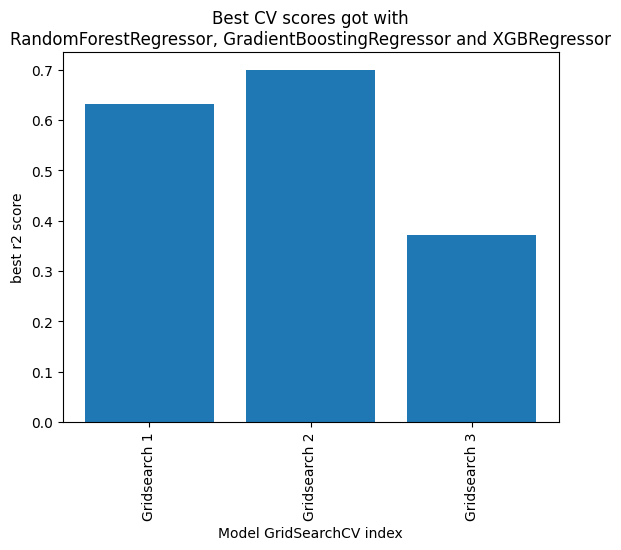

In [ ]:
plt.bar(data= tab_result,
        x= ['Gridsearch 1', 'Gridsearch 2', 'Gridsearch 3'],
        height='best_score_')
plt.xticks(rotation= 90)
plt.ylabel('best r2 score')
plt.xlabel('Model GridSearchCV index')
plt.title('Best CV scores got with\nRandomForestRegressor, GradientBoostingRegressor and XGBRegressor')

Le gradient boosting donne les meilleurs scores en moyenne avec le paramètrage ci-dessous :

In [ ]:
tab_result.iloc[1,0]

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}

### Validation curve

Nous allons maintenant optimiser le nombre d'estimateurs sur ce paramèrage.

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

def validation_curve_(model,hyperparam,param_range,cv, X_train= X_train, y_train= y_train):
  train_score, val_score = validation_curve(model, X_train, y_train,
                                             param_name = hyperparam, param_range = param_range, cv = cv)

  plt.plot(param_range, val_score.mean(axis=1), label='validation')
  plt.plot(param_range, train_score.mean(axis=1), label='train')

  plt.ylabel('score')
  plt.xlabel(hyperparam)
  plt.grid()
  plt.legend()


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

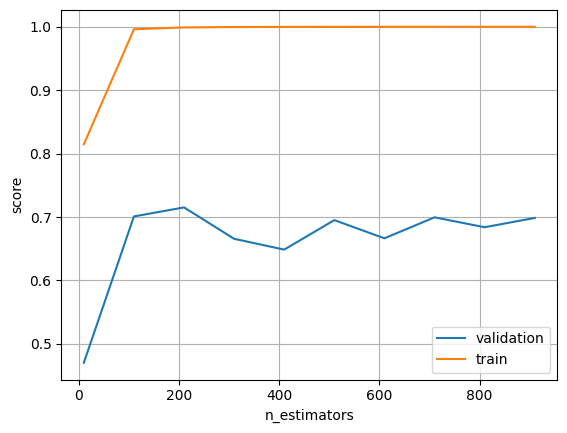

In [ ]:
skf = KFold(n_splits=5, shuffle=True, random_state=42)

validation_curve_(model = GradientBoostingRegressor(max_depth = 5,
                                              max_features = 'sqrt'),
                  hyperparam = 'n_estimators',
                  param_range = np.arange(10,1000,100),
                  cv = skf.split(X_train,y_train))

Visiblement le score atteint un maximum à partir d'un nombre d'estimateurs autour de 200.

On peut cependant noter que le modèle overfit car l'écart entre les scores sur les sets d'entraînement et de validation est assez important.

## Model evalution on testset

In [ ]:
model_ = GradientBoostingRegressor(max_depth = 5,
                                  max_features = 'sqrt',
                                  n_estimators=200)
model_.fit(X_train, y_train) #.drop(['RationNaturalGazUse', 'Storage'], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(max_depth=5, max_features='sqrt', n_estimators=200)

In [ ]:
model_.score(X_test, y_test), model_.score(X_train, y_train)

(0.602552181507026, 0.9983546450001153)

Text(73.4883970141407, 47.58, 'R² = 0.78')

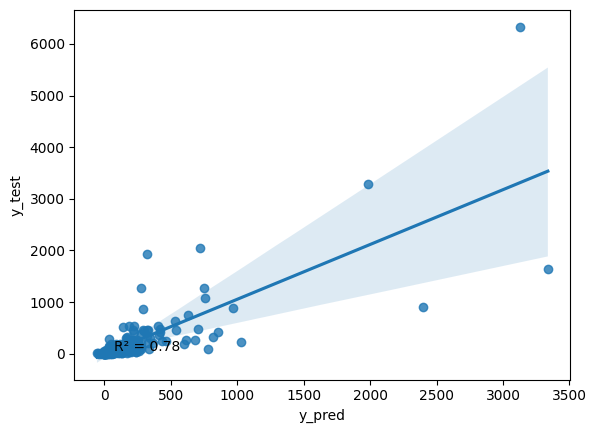

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

y_pred=model_.predict(X_test)#model_.predict(X.loc[y_test.index,:])
S1=pd.Series(y_pred.reshape(1,-1)[0])
S2=pd.Series(np.array(y_test).reshape(1,-1)[0])
pears=pd.concat([S1,S2], axis=1, ignore_index=True).corr().iloc[1,0]

sns.regplot(x=y_pred,y=np.array(y_test).reshape(1,-1)[0])
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.text(x=np.median(y_pred),y=np.median(y_test),s=f'R² = {str(round(pears,2))}')

In [ ]:
MSE = mean_squared_error(np.array(y_test).reshape(1,-1)[0],np.array(y_pred).reshape(1,-1)[0])
r2 = r2_score(np.array(y_test).reshape(1,-1)[0],np.array(y_pred).reshape(1,-1)[0])
MAPE = mean_absolute_percentage_error(np.array(y_test).reshape(1,-1)[0],np.array(y_pred).reshape(1,-1)[0])

print(f'r2_score : {round(r2,2)}\n',
      f'mean_absolute_percentage_error : {round(MAPE*100,2)} %\n',
      f'coef pearson btw predict and true : {round(pears,2)}')

r2_score : 0.6
 mean_absolute_percentage_error : 185.46 %
 coef pearson btw predict and true : 0.78


Les résultats ne sont pas encore très bons.

Nous allons maintenant optimiser le nombre d'estimateurs sur ce paramèrage.

## Feature importance

### Permutation importance

Nous pouvons faire une première analyse des variables importantes pour le modèle avec SHAP en comparaison avec celles qui sont les plus exploitées par le modèle via la méthode feature_importance_.

In [ ]:
from sklearn.inspection import permutation_importance

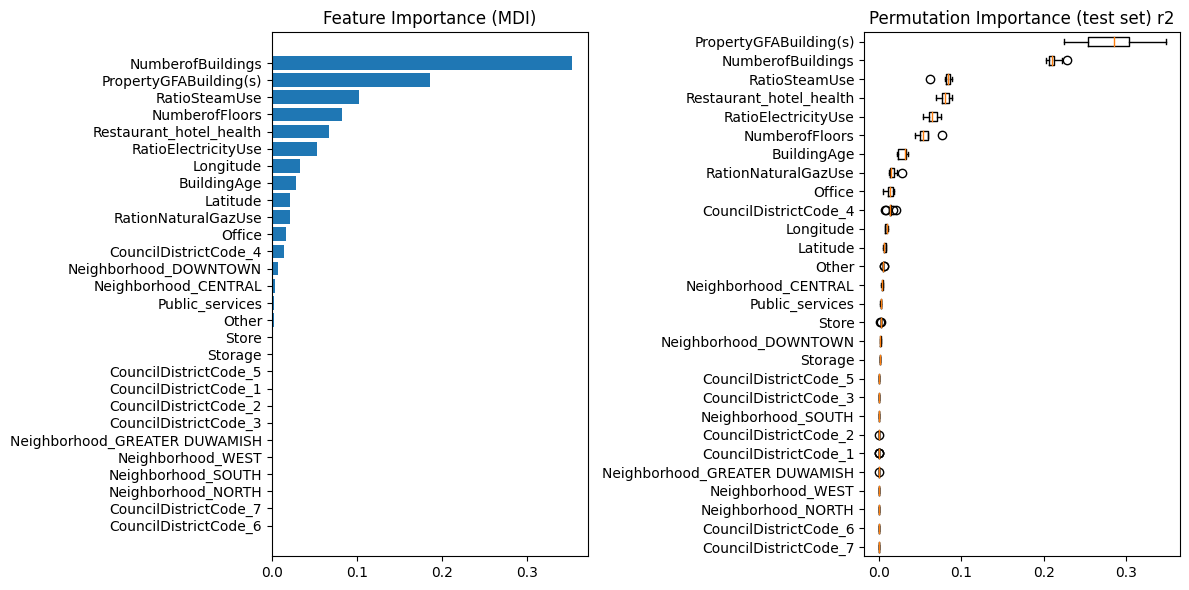

In [ ]:
feature_importance = model_.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_test.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")


result = permutation_importance(
    model_, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2,
    scoring = ['r2', 'neg_mean_squared_error']
) #.drop(['RationNaturalGazUse', 'Storage'], axis=1)

sorted_idx_r2 = result['r2']['importances_mean'].argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result['r2']['importances'][sorted_idx_r2].T,
    vert=False,
    labels=np.array(X_test.columns)[sorted_idx_r2],
)
plt.title("Permutation Importance (test set) r2")

fig.tight_layout()
plt.show()

### SHAP analysis

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.Explainer(model_)
shape_values = explainer(X_train) #.drop(['RationNaturalGazUse', 'Storage'], axis=1)

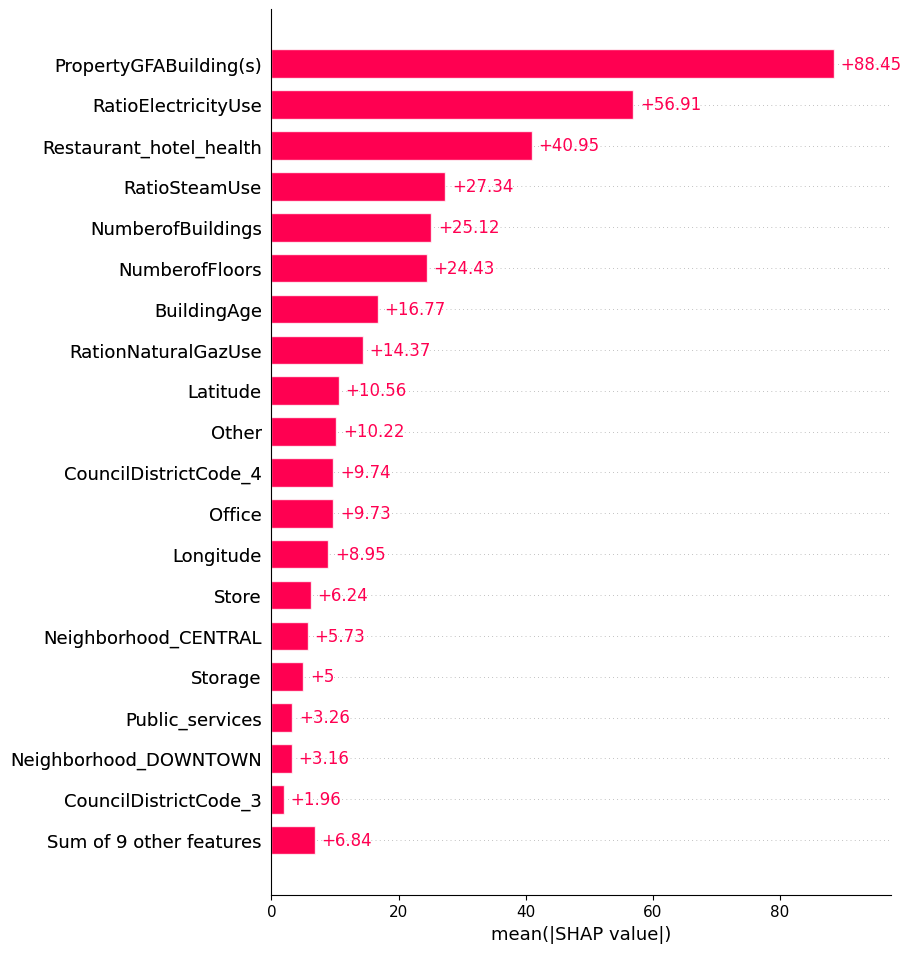

In [ ]:
shap.plots.bar(shape_values, max_display=20)

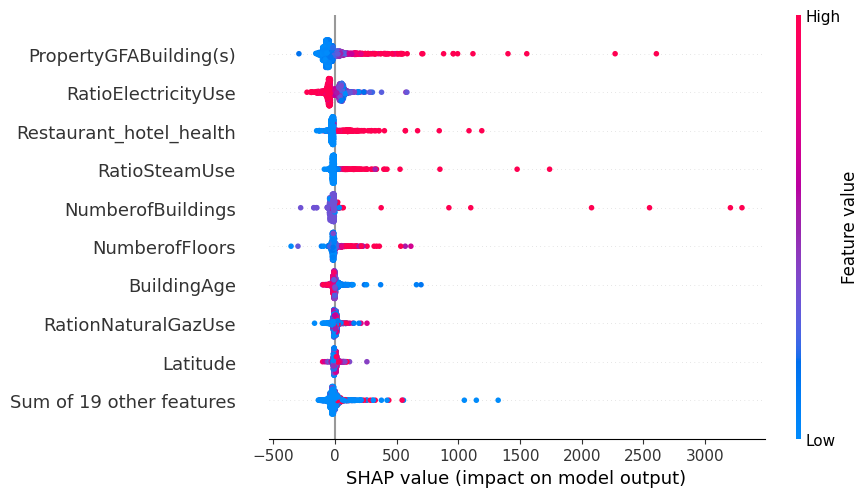

In [ ]:
shap.plots.beeswarm(shape_values)

D'après les différences entre le feature importance et le shap importance, le modèle semble overfitter avec NumberofBuilding, Latitude et RatioNaturalGazUse.

# Model and feature setting

## Feature engineering large

Nous allons maintenant balayer un grand nombre de configuration d'entrées avec notre estimateur pour trouver celles qui optimise le mieux ses performances.

In [ ]:
Feat_eng_dict = {
    'Featuring 4': {
        'std': [],
        'Minmax': [],
        'yeojohnson': []
    },
    'Featuring 5': {
        'std': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store'],
        'Minmax': [],
        'yeojohnson': []
    },
    'Featuring 6': {
        'std': [],
        'Minmax': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store'],
        'yeojohnson': []
    },
    'Featuring 7': {
        'std': [],
        'Minmax': [],
        'yeojohnson': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']
    },
    'Featuring 1b': {
        'std': ['RatioSteamUse', 'RatioElectricityUse', 'PropertyGFABuilding(s)', 'BuildingAge', 'NumberofFloors'],
        'Minmax': [],
        'yeojohnson': []
    },
    'Featuring 2b': {
        'std': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store'],
        'Minmax': [],
        'yeojohnson': []
    },
    'Featuring 3b': {
        'std': [],
        'Minmax': [],
        'yeojohnson': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']
    },
    'Featuring 4b': {
        'std': ['RatioSteamUse', 'RatioElectricityUse', 'PropertyGFABuilding(s)', 'BuildingAge', 'NumberofFloors'],
        'Minmax': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store'],
        'yeojohnson': []
    },
    'Featuring 5b': {
        'std': ['RatioSteamUse', 'RatioElectricityUse', 'PropertyGFABuilding(s)', 'BuildingAge', 'NumberofFloors'],
        'Minmax': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store'],
        'yeojohnson': []
    },
    'Featuring 6b': {
        'std': ['RatioSteamUse', 'RatioElectricityUse', 'PropertyGFABuilding(s)', 'BuildingAge', 'NumberofFloors'],
        'Minmax': [],
        'yeojohnson': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']
    },
    'Featuring 7b': {
        'std': [],
        'Minmax': ['RatioSteamUse', 'RatioElectricityUse', 'PropertyGFABuilding(s)', 'BuildingAge', 'NumberofFloors'],
        'yeojohnson': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']
    },
    'Featuring 8b': { #'RatioElectricityUse', 'PropertyGFABuilding(s)', 'BuildingAge', 'NumberofFloors'
        'std': [],
        'Minmax': ['NumberofFloors', 'BuildingAge', 'PropertyGFABuilding(s)'],
        'yeojohnson': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']
    },
    'Featuring 9b': { #'RatioElectricityUse', 'PropertyGFABuilding(s)', 'BuildingAge', 'NumberofFloors'
        'std': ['PropertyGFABuilding(s)'],
        'Minmax': ['NumberofFloors', 'BuildingAge'],
        'yeojohnson': ['Other', 'BuildingAge', 'Restaurant_hotel_health',
       'Storage','RatioElectricityUse', 'BuildingAge']
    }
}

# normalisation de la target
y_copy = StandardScaler().fit_transform(y.copy())

# autre process particuliers sur X :
X_copy = X.copy()
#X['RatioElectricityUse'] = X['RatioElectricityUse']/100
#X['RatioSteamUse'] = X['RatioSteamUse']/100

TABLE_2 = Cross_Val_Tab(model_, ('neg_root_mean_squared_error','r2'), Feat_eng_dict, X_copy, y_copy)
TABLE_2

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

,neg_root_mean_squared_error,r2
Featuring 4,-0.510913,0.675786
Featuring 5,-0.505353,0.633670
Featuring 6,-0.476846,0.686912
Featuring 7,-0.480540,0.690040
Featuring 1b,-0.489431,0.628922
Featuring 2b,-0.514800,0.677146
Featuring 3b,-0.442190,0.737002
Featuring 4b,-0.509056,0.583644
Featuring 5b,-0.488951,0.703549
Featuring 6b,-0.497428,0.674857


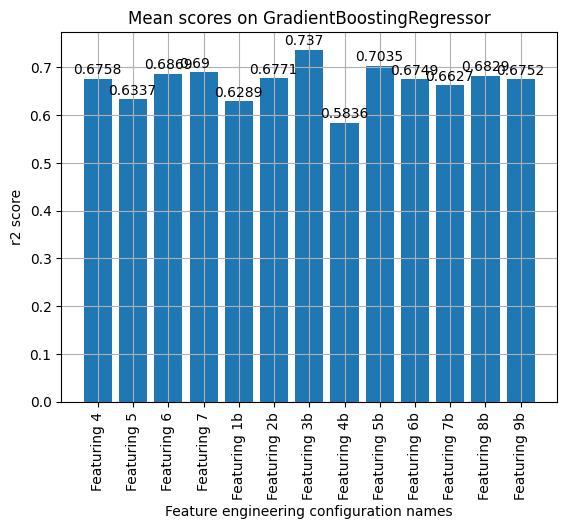

In [ ]:
plt.bar(data= TABLE_2,
        x= TABLE_2.index,
        height='r2')
plt.xticks(rotation= 90)
plt.ylabel('r2 score')
plt.xlabel('Feature engineering configuration names')
plt.title('Mean scores on GradientBoostingRegressor')
plt.grid()
c=-1
for i in TABLE_2.index:
  c+=1
  plt.text(x=c-0.7, y=TABLE_2['r2'][i]+0.01, s= round(TABLE_2['r2'][i], 4))

En faisant une cross validation du meilleur modèle en reprenant les configurations de feature engineering précédentes et de nouvelles configuration nous obtenons tout de même un score de plus de 0.7 sur les configuration 3b et 5b.

## Feature engineering ajusted

Nous allons reprendre les configuration qui marchent le mieux et rajouter quelques transformations mannuellement pour voir s'il est possible d'obtnir de meilleurs scores.

In [ ]:
Feat_eng_dict = {
    'Featuring 3b': {
        'std': [],
        'Minmax': [],
        'yeojohnson': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']
    },
    'Featuring 5b': {
        'std': ['RatioSteamUse', 'RatioElectricityUse', 'PropertyGFABuilding(s)', 'BuildingAge', 'NumberofFloors'],
        'Minmax': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store'],
        'yeojohnson': []
    },
    'Featuring 3b_2': {
        'std': ['PropertyGFABuilding(s)', 'NumberofBuildings'],
        'Minmax': [],
        'yeojohnson': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']
    },
    'Featuring 5b_2': {
        'std': ['RatioSteamUse', 'RatioElectricityUse', 'BuildingAge', 'NumberofFloors', 'RationNaturalGazUse'],
        'Minmax': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store'],
        'yeojohnson': ['PropertyGFABuilding(s)', 'NumberofBuildings', 'Latitude', 'Longitude']
    },
    'Featuring 9b': { # yeojohnson sur les plus important selon SHAP
        'std': [],
        'Minmax': [],
        'yeojohnson': ['RatioSteamUse', 'Storage', 'Office', 'Other', 'RationNaturalGazUse' ,'RatioElectricityUse', 'BuildingAge', 'NumberofFloors', 'Restaurant_hotel_health', 'PropertyGFABuilding(s)', 'NumberofBuildings', 'Latitude', 'Longitude']
    },
    'Featuring 10b': { # yeojohnson sur les plus important selon SHAP + normalisation latitude/longitude
        'std': [],
        'Minmax': [],
        'yeojohnson': ['Latitude', 'Longitude', 'RatioSteamUse', 'Storage', 'Office', 'Other', 'RationNaturalGazUse' ,'RatioElectricityUse', 'BuildingAge', 'NumberofFloors', 'Restaurant_hotel_health', 'PropertyGFABuilding(s)', 'NumberofBuildings']
    }
}

In [ ]:
# normalisation de la target
y_copy = pd.Series(yeojohnson(y.copy())[0].reshape(1,-1)[0],name='TotalGHGEmissions' ,index=y.index) #np.log(y) #StandardScaler().fit_transform(y.copy())

# autre process particuliers sur X :
X_copy = X.copy()

TABLE_3_1 = Cross_Val_Tab(model_, ('neg_root_mean_squared_error','r2'), Feat_eng_dict, X_copy, y_copy)
TABLE_3_1

,neg_root_mean_squared_error,r2
Featuring 3b,-0.599678,0.775744
Featuring 5b,-0.609101,0.768663
Featuring 3b_2,-0.617865,0.762307
Featuring 5b_2,-0.610971,0.767316
Featuring 9b,-0.607039,0.770389
Featuring 10b,-0.611258,0.766946


In [ ]:
# normalisation de la target
y_copy = StandardScaler().fit_transform(y.copy())

# autre process particuliers sur X :
X_copy = X.copy()

TABLE_3_2 = Cross_Val_Tab(model_, ('neg_root_mean_squared_error','r2'), Feat_eng_dict, X_copy, y_copy)
TABLE_3_2

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

,neg_root_mean_squared_error,r2
Featuring 3b,-0.489175,0.679474
Featuring 5b,-0.474223,0.713123
Featuring 3b_2,-0.467492,0.663869
Featuring 5b_2,-0.469333,0.709741
Featuring 9b,-0.469635,0.626714
Featuring 10b,-0.486570,0.611621


In [ ]:
# normalisation de la target
y_copy = StandardScaler().fit_transform(y.copy())

# autre process particuliers sur X :
X_copy = X.copy()
X_copy['RatioElectricityUse'] = X['RatioElectricityUse']/100
X_copy['RatioSteamUse'] = X['RatioSteamUse']/100
X_copy['RationNaturalGazUse'] = X['RationNaturalGazUse']/100

TABLE_3_3 = Cross_Val_Tab(model_, ('neg_root_mean_squared_error','r2'), Feat_eng_dict, X_copy, y_copy)
TABLE_3_3

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

,neg_root_mean_squared_error,r2
Featuring 3b,-0.451783,0.689881
Featuring 5b,-0.514915,0.638814
Featuring 3b_2,-0.511333,0.632619
Featuring 5b_2,-0.535530,0.579440
Featuring 9b,-0.431314,0.723332
Featuring 10b,-0.444853,0.720410


In [ ]:
# normalisation de la target
y_copy = pd.Series(yeojohnson(y.copy())[0].reshape(1,-1)[0],name='TotalGHGEmissions' ,index=y.index)

# autre process particuliers sur X :
X_copy = X.copy()
X_copy['RatioElectricityUse'] = X['RatioElectricityUse']/100
X_copy['RatioSteamUse'] = X['RatioSteamUse']/100
X_copy['RationNaturalGazUse'] = X['RationNaturalGazUse']/100

TABLE_3_4 = Cross_Val_Tab(model_, ('neg_root_mean_squared_error','r2'), Feat_eng_dict, X_copy, y_copy)
TABLE_3_4

,neg_root_mean_squared_error,r2
Featuring 3b,-0.607909,0.769590
Featuring 5b,-0.602861,0.773048
Featuring 3b_2,-0.611482,0.766791
Featuring 5b_2,-0.615996,0.763336
Featuring 9b,-0.610879,0.767173
Featuring 10b,-0.605513,0.771478


In [ ]:
# normalisation de la target
y_copy = pd.Series(yeojohnson(y.copy())[0].reshape(1,-1)[0],name='TotalGHGEmissions' ,index=y.index)

# autre process particuliers sur X :
X_copy = X.copy()

TABLE_3_5 = Cross_Val_Tab(model_, ('neg_root_mean_squared_error','r2'), Feat_eng_dict, X_copy, y_copy)
TABLE_3_5

,neg_root_mean_squared_error,r2
Featuring 3b,-0.607038,0.770314
Featuring 5b,-0.608076,0.769532
Featuring 3b_2,-0.605372,0.771526
Featuring 5b_2,-0.610415,0.767920
Featuring 9b,-0.604968,0.771740
Featuring 10b,-0.600052,0.775599


<Axes: >

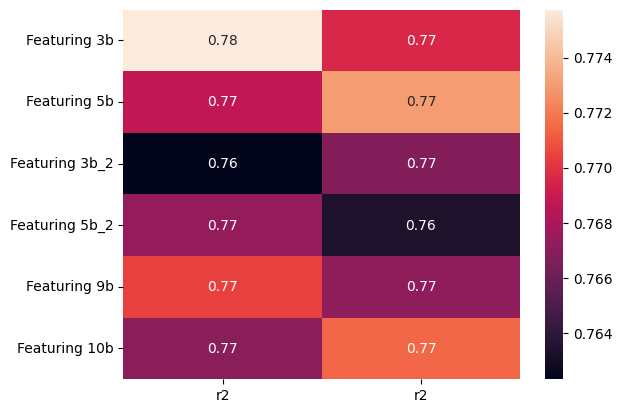

In [ ]:
sns.heatmap(pd.concat([TABLE_3_1['r2'], TABLE_3_4['r2']], axis= 1),
            annot=True, fmt='.2G')

<Axes: >

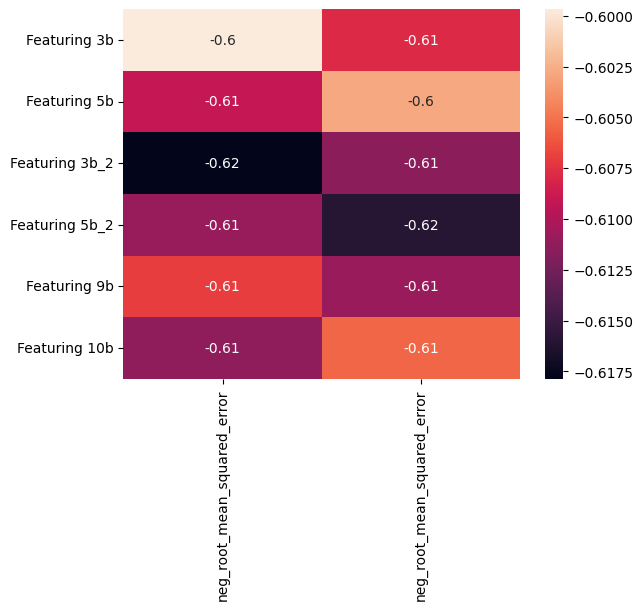

In [ ]:
sns.heatmap(pd.concat([TABLE_3_1['neg_root_mean_squared_error'], TABLE_3_4['neg_root_mean_squared_error']], axis= 1),
            annot=True, fmt='.2G')

## Feature engineering selection

Parmis les résultats, nous retiendrons la configuration 3b avec yeojohnson sur la target qui donne les meilleurs résultats moyens.

In [ ]:
# 3b + yeojohnson target

# config 3b
col_std, col_mM, col_yeo =  [],[], ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']
# normalisation de la target
y_copy = pd.Series(yeojohnson(y.copy())[0].reshape(1,-1)[0],name='TotalGHGEmissions' ,index=y.index) #StandardScaler().fit_transform(y.copy())

# autre process particuliers sur X :
X_copy = X.copy()

X_train, X_test, y_train, y_test = preprocessing_tsf(col_std, col_mM, col_yeo, X=X_copy, y= y_copy)

Testons à nouveau le modèle sur le nombre d'estimateurs avec la nouvelle configuration d'entrées.

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

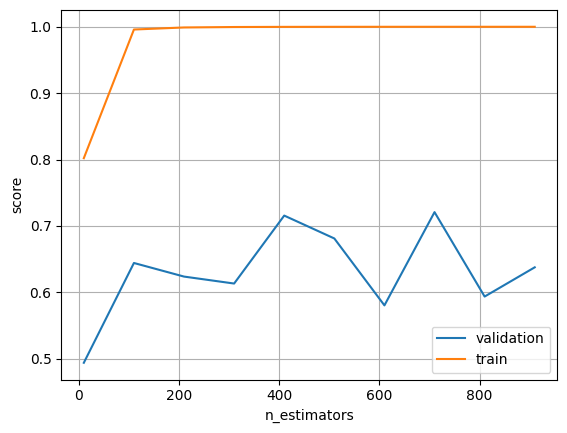

In [ ]:
skf = KFold(n_splits=5, shuffle=True, random_state=42)

validation_curve_(model = model_,
                  hyperparam = 'n_estimators',
                  param_range = np.arange(10,1000,100),
                  cv = skf.split(X_train,y_train))

Le modèle a un pique de performance vers n_estimators = 400.

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

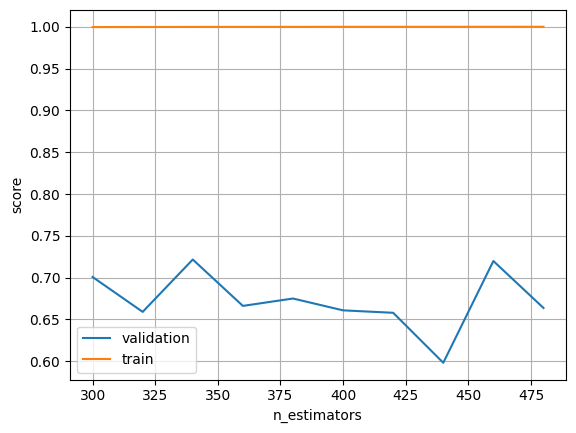

In [ ]:
validation_curve_(model = model_,
                  hyperparam = 'n_estimators',
                  param_range = np.arange(300,500,20),
                  cv = skf.split(X_train,y_train))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

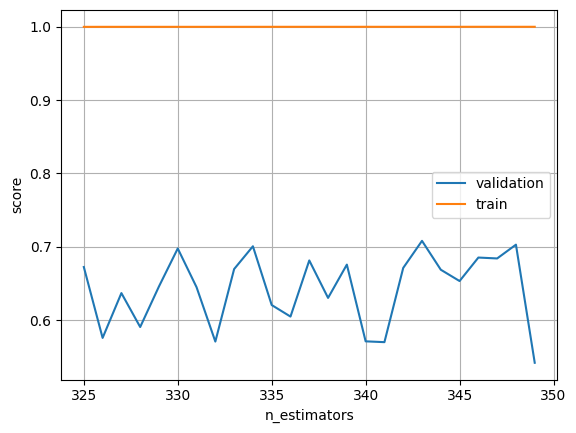

In [ ]:
validation_curve_(model = model_,
                  hyperparam = 'n_estimators',
                  param_range = np.arange(325,350,1),
                  cv = skf.split(X_train,y_train))

Nous retiendrons n_estimators = 343.

In [ ]:
model_ = GradientBoostingRegressor(max_depth = 5,
                                  max_features = 'sqrt',
                                  n_estimators=343)
model_.fit(X_train, y_train) #.drop(['RationNaturalGazUse', 'Storage'], axis=1)

GradientBoostingRegressor(max_depth=5, max_features='sqrt', n_estimators=343)

## Feature importance

Faisons une analyse d'inmportance des variables pour avoir des éléments de comparaisons dans les parties suivantes d'optimisation du modèle.

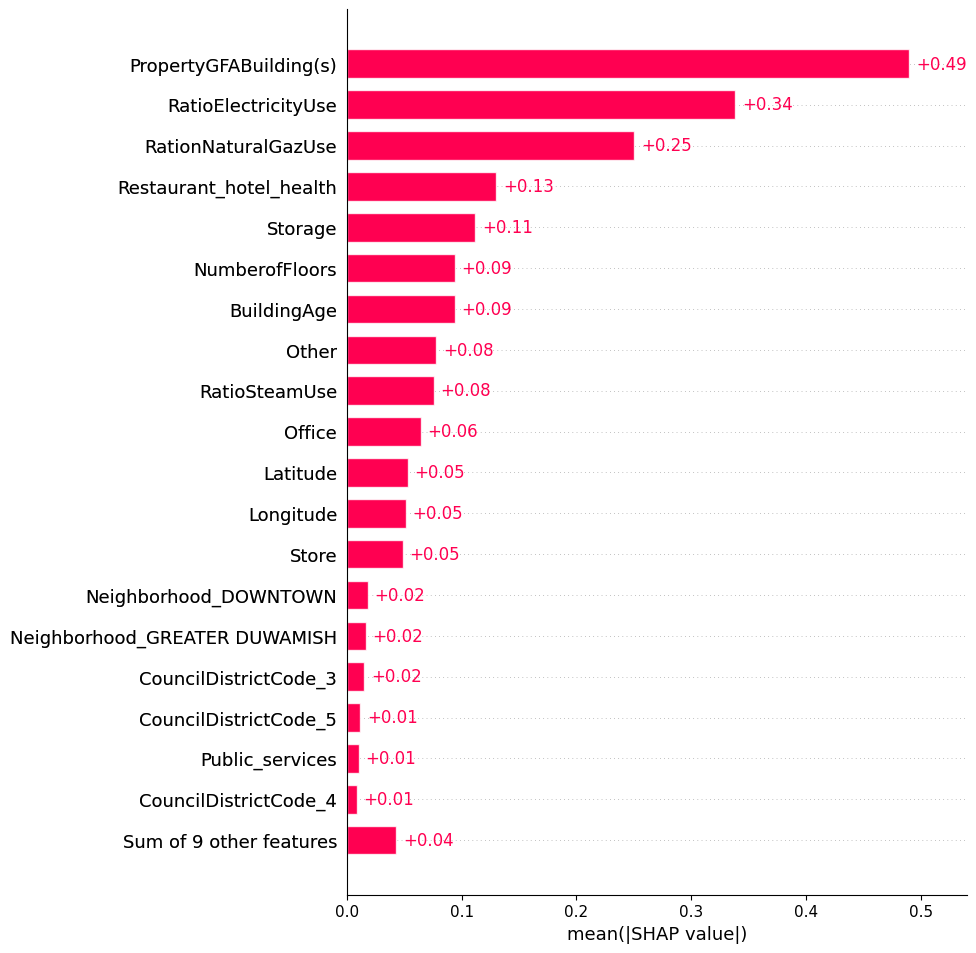

In [ ]:
explainer = shap.Explainer(model_)
shape_values = explainer(X_train)
shap.plots.bar(shape_values, max_display=20)

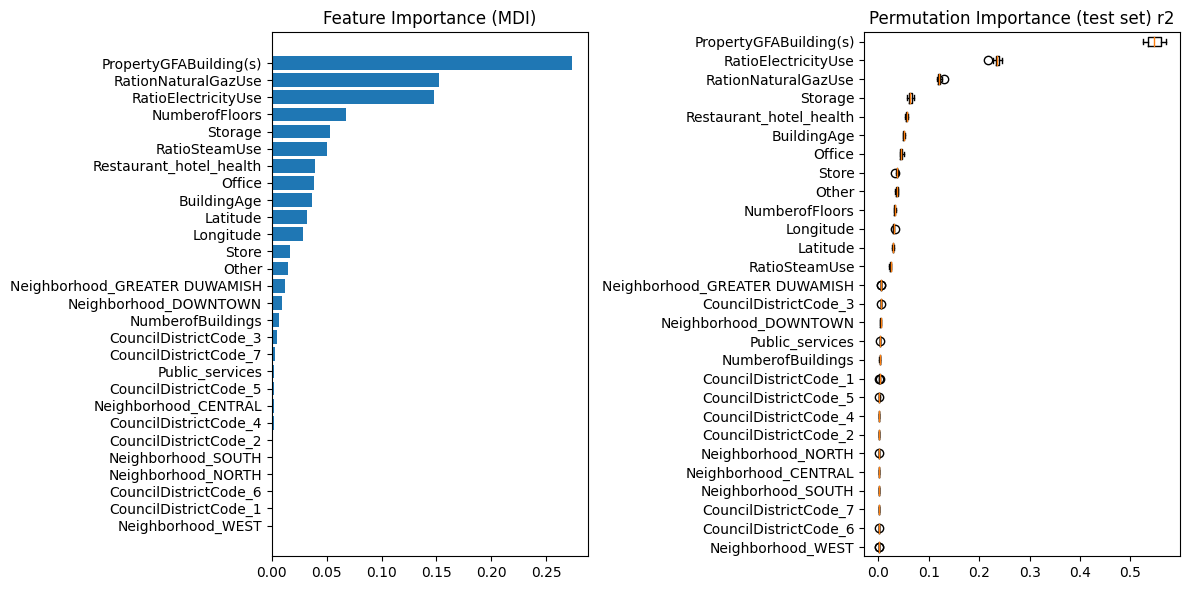

In [ ]:
feature_importance = model_.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_test.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")


result = permutation_importance(
    model_, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2,
    scoring = ['r2', 'neg_mean_squared_error']
)

sorted_idx_r2 = result['r2']['importances_mean'].argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result['r2']['importances'][sorted_idx_r2].T,
    vert=False,
    labels=np.array(X_test.columns)[sorted_idx_r2],
)
plt.title("Permutation Importance (test set) r2")

fig.tight_layout()
plt.show()

On remarque qu'un certain nombre de variables ne sont pas exploitées par le modèle.

Certaines ne sont (d'après l'analyse SHAP) même pas utiles.

## Variable VIF

divide by zero encountered in double_scalars


,features,VIF
0,Office,2.634593
1,Other,1.590930
2,Public_services,1.533094
3,Restaurant_hotel_health,1.677311
4,Storage,2.034066
5,Store,1.917144
6,Neighborhood_CENTRAL,inf
7,Neighborhood_DOWNTOWN,inf
8,Neighborhood_GREATER DUWAMISH,inf
9,Neighborhood_NORTH,inf


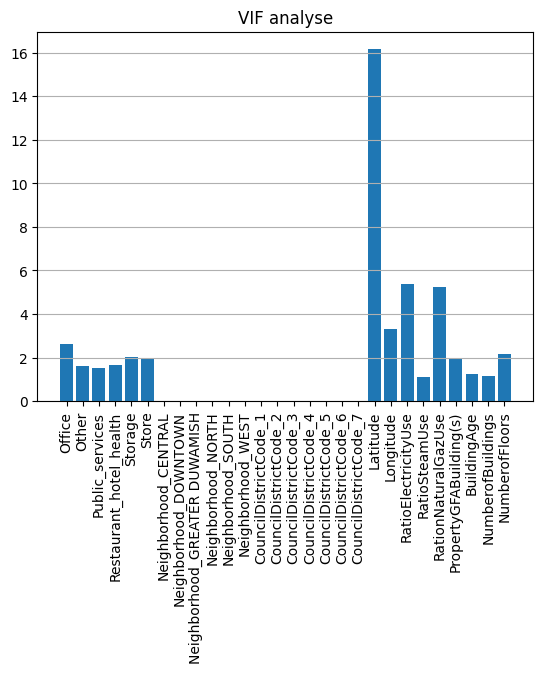

In [ ]:
#X_Cleaned = X.drop([ 'RationNaturalGazUse', 'NumberofBuildings', 'Neighborhood_GREATER DUWAMISH'] + Coordinat + Council, axis=1).fillna(0)
X_vif = X_copy.copy()#.drop(Council + ['Neighborhood_GREATER DUWAMISH'], axis = 1)
vif_analyse(X_vif) #, prints=False  Neighborhood +

On remarque également certaines fortes corrélations entre nos variables qu'il faudra traiter ultérieurement.

## Model testing

In [ ]:
model_.score(X_test, y_test)

0.7487218822233803

Text(3.7545086232409215, 3.6400684336062845, 'R² = 0.87')

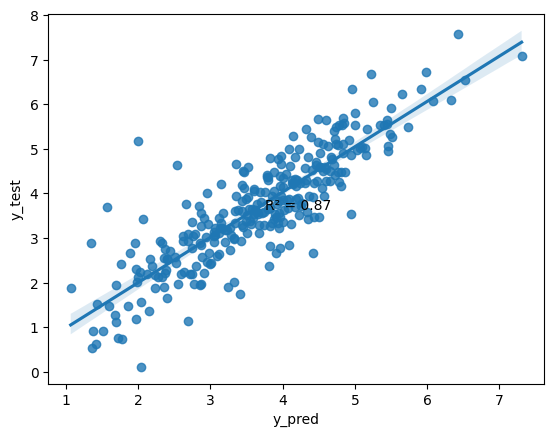

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

y_pred=model_.predict(X_test)#model_.predict(X.loc[y_test.index,:])
S1=pd.Series(y_pred.reshape(1,-1)[0])
S2=pd.Series(np.array(y_test).reshape(1,-1)[0])
pears=pd.concat([S1,S2], axis=1, ignore_index=True).corr().iloc[1,0]

sns.regplot(x=y_pred,y=np.array(y_test).reshape(1,-1)[0])
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.text(x=np.median(y_pred),y=np.median(y_test),s=f'R² = {str(round(pears,2))}')

In [ ]:
MSE = mean_squared_error(np.array(y_test).reshape(1,-1)[0],np.array(y_pred).reshape(1,-1)[0])
r2 = r2_score(np.array(y_test).reshape(1,-1)[0],np.array(y_pred).reshape(1,-1)[0])
MAPE = mean_absolute_percentage_error(np.array(y_test).reshape(1,-1)[0],np.array(y_pred).reshape(1,-1)[0])

print(f'r2_score : {round(r2,2)}\n',
      f'mean_absolute_percentage_error : {round(MAPE*100,2)} %\n',
      f'coef pearson btw predict and true : {round(pears,2)}')

r2_score : 0.75
 mean_absolute_percentage_error : 21.92 %
 coef pearson btw predict and true : 0.87


Les performances sont nettement meilleures.

## Learning curve

In [ ]:
# fonction d'évaluation du modele

from sklearn.model_selection import learning_curve # pour visu overfitting
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error # import des metrics
from sklearn.metrics import make_scorer

def evaluation(model,model_name, rdst=42):

  model.fit(X_train, y_train)
  y_pred =  model.predict(X_test)

  N, train_score, val_score = learning_curve(model, X_train, y_train,
						cv=KFold(n_splits=4, shuffle=True, random_state=rdst), scoring = 'r2',
						train_sizes=np.linspace(0.1, 1, 10))
  plt.figure(figsize=(10,6))
  plt.title(model_name)
  plt.plot(N, train_score.mean(axis=1), label='train score')
  #évolution du train_score en fonction du nombre d'échantillons qui ont servi à l'entraînement
  plt.plot(N, val_score.mean(axis=1), label='validation score')
  plt.xlabel('Qté de données')
  plt.ylabel('Score R²')
  plt.grid()
  plt.legend()

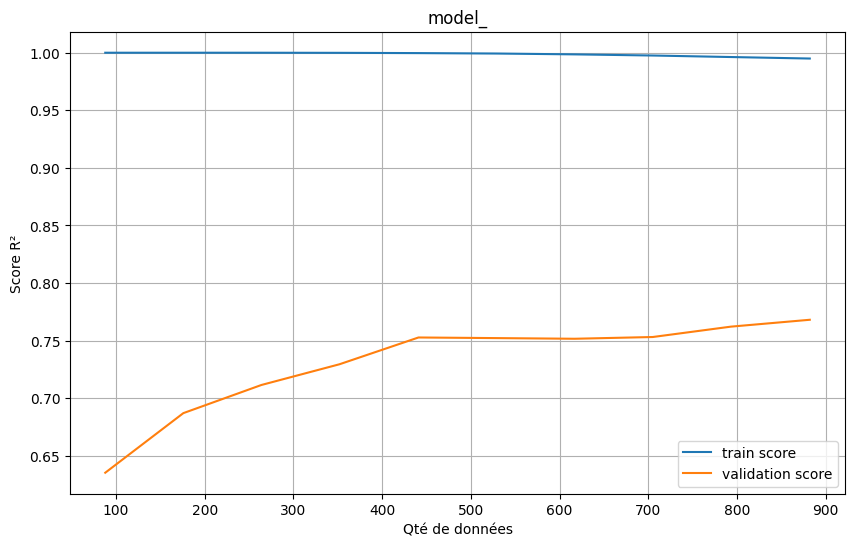

In [ ]:
evaluation(model_,'model_')

Il semblerait qu'avec une plus grande quantité de données nous pourrions optimiser d'avantage les performance du modèle.

Néanmoins, nous avons tout de même de l'overfitting sur les données d'entraînements d'après la learning curve.

# Feature removed

Nous avons vu que les coordonnées géographiques perturbent nos entrées d'près l'analyse VIF précédente.

De même pour les quartiers.

Ainsi nous pourrions supprimer une partie des entrées de localisation qui ne sont pas ou peu utilisées par le modèle dans les prédictions.

In [ ]:
#X_Cleaned = X.drop([ 'RationNaturalGazUse', 'NumberofBuildings', 'Neighborhood_GREATER DUWAMISH'] + Coordinat + Council, axis=1).fillna(0)
X_copy=X.copy()
X_vif = X_copy.copy().drop(Neighborhood + ['CouncilDistrictCode_1', 'Longitude', 'Latitude'], axis = 1)
vif_analyse(X_vif) #, prints=False  Neighborhood +

NameError: name 'X' is not defined

Les résultats VIF sont meilleurs.

Réentraînons lemodèle sur cette nouvelle base en adaptant la configuration d'entrée 10b élaborées précédemment.

In [ ]:
# config 3b
col_std, col_mM, col_yeo =  [],[], ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']# normalisation de la target

# yeojohnson target
y_copy = pd.Series(yeojohnson(y.copy())[0].reshape(1,-1)[0],name='TotalGHGEmissions' ,index=y.index) #StandardScaler().fit_transform(y.copy())

# autre process particuliers sur X :
X_copy = X.copy()
X_copy = X_copy.drop(Neighborhood + ['CouncilDistrictCode_1', 'Longitude', 'Latitude'], axis = 1)

X_train, X_test, y_train, y_test = preprocessing_tsf(col_std, col_mM, col_yeo, X=X_copy, y= y_copy)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

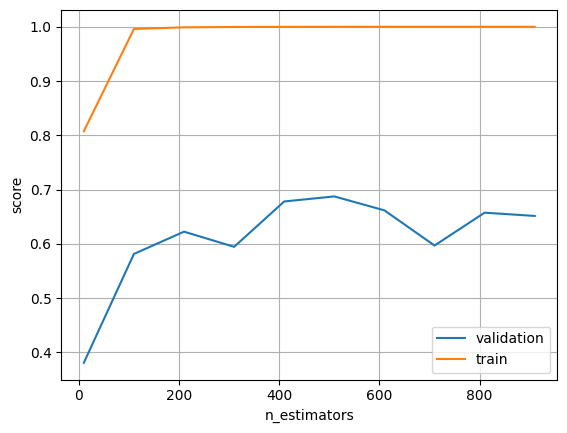

In [ ]:
skf = KFold(n_splits=5, shuffle=True, random_state=42)

validation_curve_(model = model_,
                  hyperparam = 'n_estimators',
                  param_range = np.arange(10,1000,100),
                  cv = skf.split(X_train,y_train))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

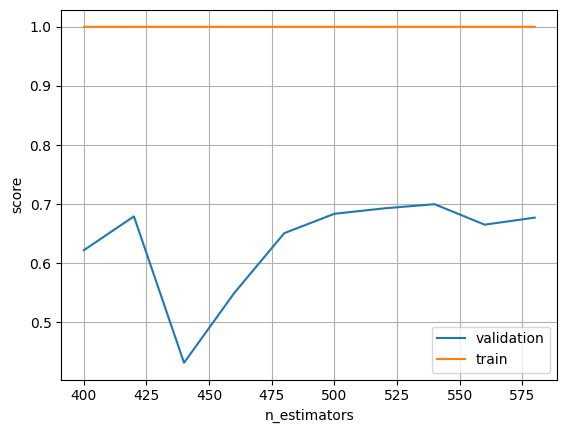

In [ ]:
validation_curve_(model = model_,
                  hyperparam = 'n_estimators',
                  param_range = np.arange(400,600,20),
                  cv = skf.split(X_train,y_train))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

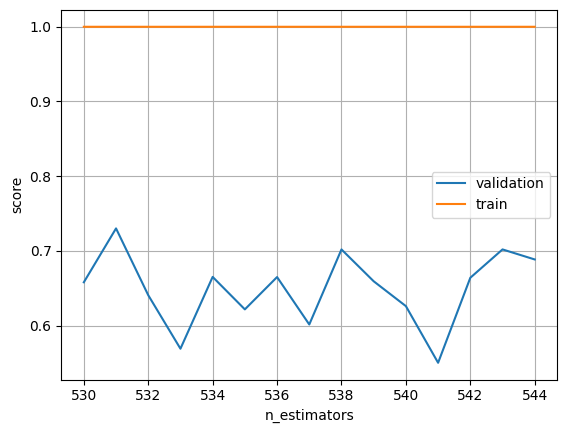

In [ ]:
validation_curve_(model = model_,
                  hyperparam = 'n_estimators',
                  param_range = np.arange(530,545,1),
                  cv = skf.split(X_train,y_train))

Nous retiendrons n_estimators = 531.

In [ ]:
model_ = GradientBoostingRegressor(max_depth = 5,
                                  max_features = 'sqrt',
                                  n_estimators=531)
model_.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, max_features='sqrt', n_estimators=531)

In [ ]:
model_.score(X_test, y_test)

0.7388601713172138

Text(3.7763179944246277, 3.6400684336062845, 'R² = 0.86')

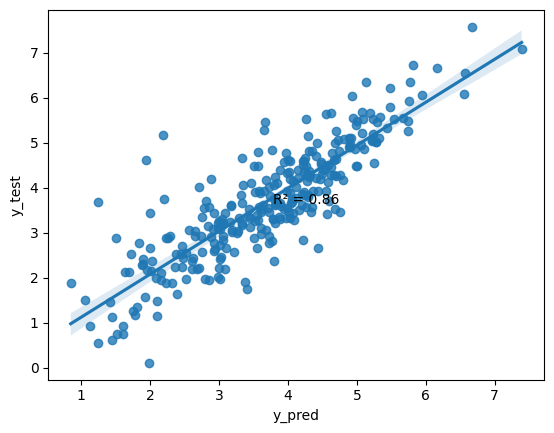

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

y_pred=model_.predict(X_test)#model_.predict(X.loc[y_test.index,:])
S1=pd.Series(y_pred.reshape(1,-1)[0])
S2=pd.Series(np.array(y_test).reshape(1,-1)[0])
pears=pd.concat([S1,S2], axis=1, ignore_index=True).corr().iloc[1,0]

sns.regplot(x=y_pred,y=np.array(y_test).reshape(1,-1)[0])
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.text(x=np.median(y_pred),y=np.median(y_test),s=f'R² = {str(round(pears,2))}')

In [ ]:
MSE = mean_squared_error(np.array(y_test).reshape(1,-1)[0],np.array(y_pred).reshape(1,-1)[0])
r2 = r2_score(np.array(y_test).reshape(1,-1)[0],np.array(y_pred).reshape(1,-1)[0])
MAPE = mean_absolute_percentage_error(np.array(y_test).reshape(1,-1)[0],np.array(y_pred).reshape(1,-1)[0])

print(f'r2_score : {round(r2,2)}\n',
      f'mean_absolute_percentage_error : {round(MAPE*100,2)} %\n',
      f'coef pearson btw predict and true : {round(pears,2)}')

r2_score : 0.74
 mean_absolute_percentage_error : 21.81 %
 coef pearson btw predict and true : 0.86


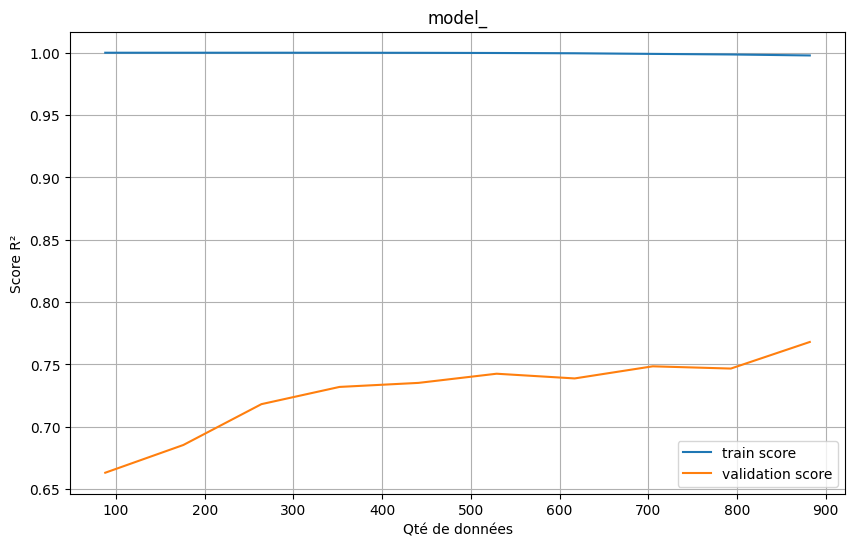

In [ ]:
evaluation(model_,'model_')

Les performances sont sensiblement les mêmes après suppression de ces éléments.

# EnergyStarScore influence

Voyons maintenant l'influence de l'EnergyStarSCore

In [ ]:
df_source=pd.read_csv('/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 4/Content/2016_Building_Energy_Benchmarking.csv',sep=',')

## Imputation NaN

{'whiskers': [<matplotlib.lines.Line2D at 0x7cccf00f80d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7cccf010a770>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7cccf00fbd30>],
 'medians': [<matplotlib.lines.Line2D at 0x7cccf01092d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7cccf010b5e0>],
 'means': [<matplotlib.lines.Line2D at 0x7cccf01095d0>]}

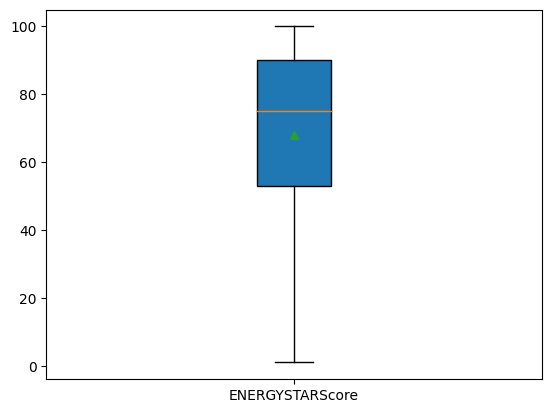

In [ ]:
plt.boxplot(df_source['ENERGYSTARScore'].dropna(), labels=['ENERGYSTARScore'], showmeans=True, showfliers=True,patch_artist=True)

In [ ]:
df_source['ENERGYSTARScore'].isna().mean()

0.2497037914691943

Nous imputons par la moyenne.

{'whiskers': [<matplotlib.lines.Line2D at 0x7ccce3547100>,
 'caps': [<matplotlib.lines.Line2D at 0x7ccce3547640>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7ccce3546cb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ccce3547af0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ccce35447c0>],
 'means': [<matplotlib.lines.Line2D at 0x7ccce3547dc0>]}

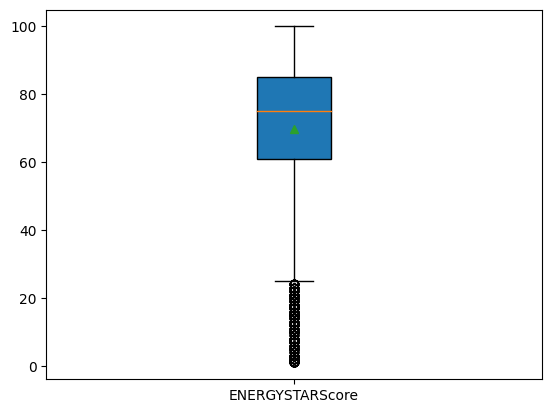

In [ ]:
plt.boxplot(df_source['ENERGYSTARScore'].fillna(df_source['ENERGYSTARScore'].median()), labels=['ENERGYSTARScore'], showmeans=True, showfliers=True,patch_artist=True)

In [ ]:
D_star_1 = df_source['ENERGYSTARScore'].fillna(df_source['ENERGYSTARScore'].median()).copy()

## Implementation in model

Testons la configuration 3b en variant sur la transformation de la nouvelle variable.

In [ ]:
Feat_eng_dict = {
    'Featuring 3b': {
        'std': [],
        'Minmax': [],
        'yeojohnson': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']
    },
    'Featuring 10b1': { # yeojohnson sur les plus important selon SHAP + normalisation latitude/longitude
        'std': ['ENERGYSTARScore'],
        'Minmax': [],
        'yeojohnson': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']
    },
    'Featuring 10b2': { # yeojohnson sur les plus important selon SHAP + normalisation latitude/longitude
        'std': [],
        'Minmax': ['ENERGYSTARScore'],
        'yeojohnson': ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']
    },
    'Featuring 10b3': { # yeojohnson sur les plus important selon SHAP + normalisation latitude/longitude
        'std': [],
        'Minmax': [],
        'yeojohnson': ['ENERGYSTARScore', 'Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']
    }
}

In [ ]:
X = pd.concat([X, D_star_1], axis = 1, join='inner') # ajout de l'energystarscore

In [ ]:
# normalisation de la target
y_copy = pd.Series(yeojohnson(y.copy())[0].reshape(1,-1)[0],name='TotalGHGEmissions' ,index=y.index)

# autre process particuliers sur X :
X_copy = X.copy()
X_copy = X_copy.drop(Neighborhood + ['CouncilDistrictCode_1', 'Longitude', 'Latitude', 'RationNaturalGazUse'], axis = 1)

TABLE_5 = Cross_Val_Tab(model_, ('neg_root_mean_squared_error','r2'), Feat_eng_dict, X_copy, y_copy)
TABLE_5

,neg_root_mean_squared_error,r2
Featuring 3b,-0.614823,0.764308
Featuring 10b1,-0.616456,0.763170
Featuring 10b2,-0.617150,0.762551
Featuring 10b3,-0.621613,0.759074


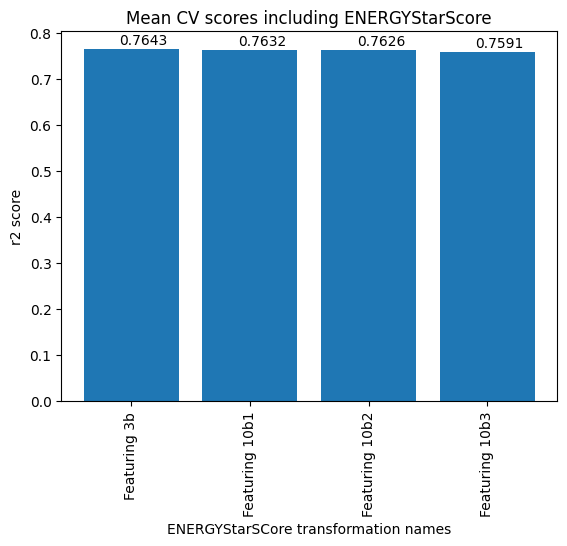

In [ ]:
plt.bar(data= TABLE_5,
        x= TABLE_5.index,
        height='r2')
plt.xticks(rotation= 90)
plt.ylabel('r2 score')
plt.xlabel('ENERGYStarSCore transformation names')
plt.title('Mean CV scores including ENERGYStarScore')
c=-1
for i in TABLE_5.index:
  c+=1
  plt.text(x= c-.1,y= TABLE_5['r2'][i]+.01,s= round(TABLE_5['r2'][i], 4))

In [ ]:
# normalisation de la target
y_copy = pd.Series(yeojohnson(y.copy())[0].reshape(1,-1)[0],name='TotalGHGEmissions' ,index=y.index)

# autre process particuliers sur X :
X_copy = X.copy()
X_copy = X_copy.drop(Neighborhood + ['CouncilDistrictCode_1', 'Longitude', 'Latitude', 'RationNaturalGazUse'], axis = 1)

X_copy['ENERGYSTARScore'] = X['ENERGYSTARScore']/100

TABLE_5_2 = Cross_Val_Tab(model_, ('neg_root_mean_squared_error','r2'), Feat_eng_dict, X_copy, y_copy)
TABLE_5_2

,neg_root_mean_squared_error,r2
Featuring 3b,-0.614144,0.764826
Featuring 10b1,-0.615654,0.763860
Featuring 10b2,-0.617916,0.762077
Featuring 10b3,-0.619612,0.760734


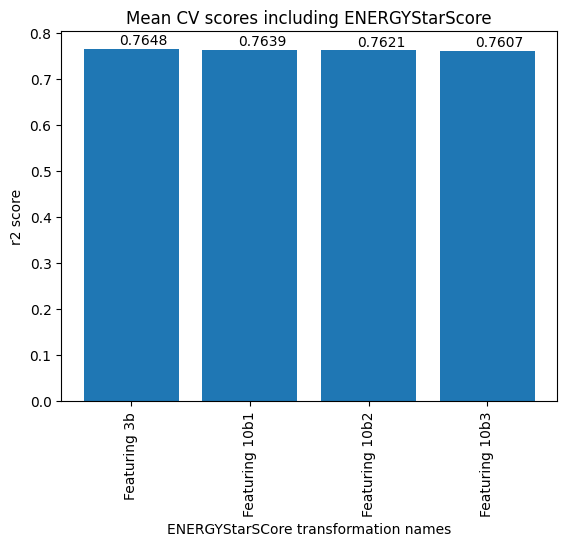

In [ ]:
plt.bar(data= TABLE_5_2,
        x= TABLE_5_2.index,
        height='r2')
plt.xticks(rotation= 90)
plt.ylabel('r2 score')
plt.xlabel('ENERGYStarSCore transformation names')
plt.title('Mean CV scores including ENERGYStarScore')
c=-1
for i in TABLE_5_2.index:
  c+=1
  plt.text(x= c-.1,y= TABLE_5_2['r2'][i]+.01,s= round(TABLE_5_2['r2'][i], 4))

La configuration 3b avec division par 100 de l'Energystartscore donne le meilleur score.

In [ ]:
# 3b + yeo target + suppression des features après analyse VIF + starscore/100

# config 3b
col_std, col_mM, col_yeo =  [],[], ['Office', 'Other', 'Public_services', 'Restaurant_hotel_health',
       'Storage', 'Store']

# normalisation de la target
y_copy = pd.Series(yeojohnson(y.copy())[0].reshape(1,-1)[0],name='TotalGHGEmissions' ,index=y.index)

# autre process particuliers sur X :
X_copy = X.copy()
X_copy = X_copy.drop(Neighborhood + ['CouncilDistrictCode_1', 'Longitude', 'Latitude', 'RationNaturalGazUse'], axis = 1)
X_copy['ENERGYSTARScore'] = X['ENERGYSTARScore']/100

X_train, X_test, y_train, y_test = preprocessing_tsf(col_std, col_mM, col_yeo, X=X_copy, y= y_copy)

In [ ]:
model_.fit(X_train, y_train)
model_.score(X_test, y_test)

0.7218358716786243

Text(3.7359026985933634, 3.6400684336062845, 'R² = 0.85')

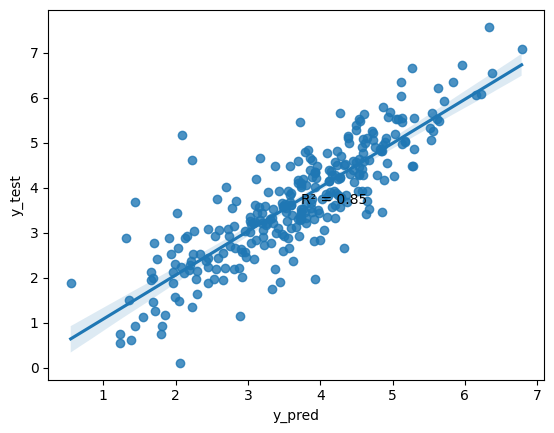

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

y_pred=model_.predict(X_test)#model_.predict(X.loc[y_test.index,:])
S1=pd.Series(y_pred.reshape(1,-1)[0])
S2=pd.Series(np.array(y_test).reshape(1,-1)[0])
pears=pd.concat([S1,S2], axis=1, ignore_index=True).corr().iloc[1,0]

sns.regplot(x=y_pred,y=np.array(y_test).reshape(1,-1)[0])
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.text(x=np.median(y_pred),y=np.median(y_test),s=f'R² = {str(round(pears,2))}')

In [ ]:
MSE = mean_squared_error(np.array(y_test).reshape(1,-1)[0],np.array(y_pred).reshape(1,-1)[0])
r2 = r2_score(np.array(y_test).reshape(1,-1)[0],np.array(y_pred).reshape(1,-1)[0])
MAPE = mean_absolute_percentage_error(np.array(y_test).reshape(1,-1)[0],np.array(y_pred).reshape(1,-1)[0])

print(f'r2_score : {round(r2,2)}\n',
      f'mean_absolute_percentage_error : {round(MAPE*100,2)} %\n',
      f'coef pearson btw predict and true : {round(pears,2)}')

r2_score : 0.72
 mean_absolute_percentage_error : 22.79 %
 coef pearson btw predict and true : 0.85


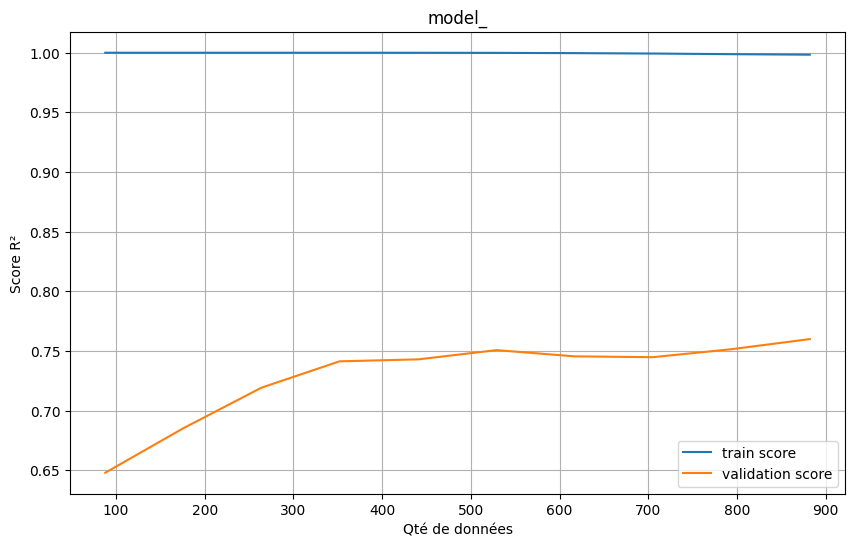

In [ ]:
evaluation(model_,'model_')

Après insersion de la variables dans l'entraînement du modèle nous pouvons dire que celle-ci n'a pas une grande influence sur ses performances.

L'EnergyStarscore n'est pas nécessairement pertiente au vu de la difficulté pour l'optenir.